# 1) Data Exploration

In [1]:
import urllib
import tifffile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import PIL
import os


from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

from sklearn import set_config; set_config(display='diagram')

In [2]:
## Imports
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

## Seeding 
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

2022-12-01 10:22:46.766416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import Input
from tensorflow.keras import layers, Model,Sequential
from tensorflow import squeeze

## 1.1) Load Data

- We will use 2 to 3 images of both S1 and S2 satellites to build the model. Right now, the dimensionality of the input and output need to be decided first.
- Data from 1 chip_id "000aa810" is in the 'data' folder from the project.
- It's also important to start working with the metadata .csv files from the project as they will help to track data for training and 
- Data is downloaded from a AWS bucket, best way to get it is by CLI. We need to install AWS CLI in this package

In [4]:
X_data = pd.read_csv('../data/features_metadata - features_metadata.csv')

In [5]:
X_data.loc[1,"s3path_eu"]

's3://drivendata-competition-biomassters-public-eu/train_features/0003d2eb_S1_01.tif'

In [6]:
y_agbm = pd.read_csv(f'../data/train_agbm_metadata.csv')
y_agbm.drop(columns=["s3path_us","s3path_as"],inplace=True)
y_agbm.loc[1,"s3path_eu"]

's3://drivendata-competition-biomassters-public-eu/train_agbm/000aa810_agbm.tif'

In [7]:
# Read tif file and get a numpy array 
def image_to_np(path, filename):
  file = os.path.abspath(f'{path}{filename}')
  return tifffile.imread(file)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, StandardScaler

In [9]:
y = image_to_np('../data/ground truth/' , '0060c0a5_agbm.tif')
XS1_non = {}
XS2_non = {}

for n in range(0,12):
    XS1_non[n] = image_to_np('../data/train data/' , f"0060c0a5_S1_{'{0}'.format(str(n).zfill(2))}.tif")
    XS2_non[n] = image_to_np('../data/train data/' , f"0060c0a5_S2_{'{0}'.format(str(n).zfill(2))}.tif")
    
    if n == 0:
        XS1_non_scaled = XS1_non[n]
        XS2_non_scaled = XS2_non[n]
         
    else:
        XS1_non_scaled = np.concatenate([XS1_non_scaled,XS1_non[n]],-1)
        XS2_non_scaled = np.concatenate([XS2_non_scaled,XS2_non[n]],-1)
XS_non_scaled = np.concatenate([XS1_non_scaled,XS2_non_scaled],-1)

In [10]:
y = image_to_np('../data/ground truth/' , '0060c0a5_agbm.tif')
precentage = 0.8
scaler = StandardScaler()
XS1 = {}
XS2 = {}

for n in range(0,12):
    XS1[n] = image_to_np('../data/train data/' , f"0060c0a5_S1_{'{0}'.format(str(n).zfill(2))}.tif")
    XS2[n] = image_to_np('../data/train data/' , f"0060c0a5_S2_{'{0}'.format(str(n).zfill(2))}.tif")
    
#     if n == 0:
#         XS1_non_scaled = XS1[n]
#         XS2_non_scaled = XS2[n]
         
#     if n >= 1:
#         XS1_non_scaled = np.concatenate([XS1_non_scaled,XS1[n]],-1)
#         XS2_non_scaled = np.concatenate([XS2_non_scaled,XS2[n]],-1)
#------
    for i in range(4):
        XS1[n][:,:,i] = scaler.fit_transform(XS1[n][:,:,i])
    for j in range(11):
        XS2[n][:,:,j] = scaler.fit_transform(XS2[n][:,:,j])
#------
    if n == 0:
        XS1_scaled = XS1[n]
        XS2_scaled = XS2[n]
    else:
        XS1_scaled = np.concatenate([XS1_scaled,XS1[n]],-1)
        XS2_scaled = np.concatenate([XS2_scaled,XS2[n]],-1)

#XS_non_scaled = np.concatenate([XS1_non_scaled,XS2_non_scaled],-1)
XS_scaled = np.concatenate([XS1_scaled,XS2_scaled],-1)

# X_train, X_test, y_train, y_test = train_test_split(XS_scaled, y, test_size=0.33)

In [11]:
np.count_nonzero(XS_scaled <= 0)

7633657

In [23]:
def build_model(input_layer, start_neurons):
    
    
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="linear")(uconv1)

    model = Model(inputs=[input_layer], outputs = [output_layer])

    return model

input_layer = Input((256, 256,180))
#output_layer = build_model(input_layer, 16)

In [24]:
model = build_model(input_layer,16)
model.compile(loss='mse',optimizer='adam',metrics=['mse'])

In [25]:
y_ = tf.expand_dims(y,axis=0)
x_ = tf.expand_dims(layerS1_0,axis=0)
x_pred_ = tf.expand_dims(layerS1_0,axis=0)


tf.config.run_functions_eagerly(True)
model.fit(x_,y_,epochs=5)
pred = model.predict(x_pred_)
predict = squeeze(pred)
model.evaluate(x_pred_,y_)

Epoch 1/5
1/1 [==============================] - 2s 2s/step - loss: 34126532.0000 - mse: 34126532.0000
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 8462338.0000 - mse: 8462338.0000
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 4224662.0000 - mse: 4224662.0000
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 2532899.0000 - mse: 2532899.0000
Epoch 5/5
1/1 [==============================] - 0s 184ms/step - loss: 370964.2500 - mse: 370964.2500


[370964.25, 370964.25]

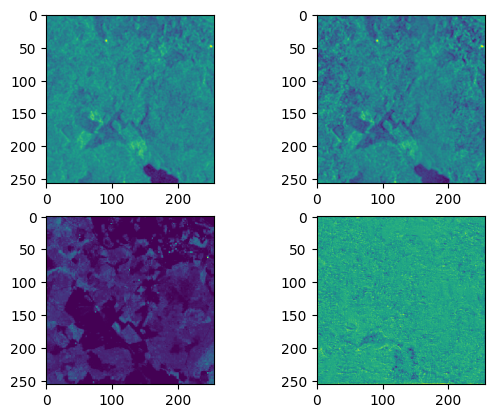

In [26]:
fig, ((ax1, ax2),( ax3, ax4)) = plt.subplots(2,2)
n=10
ax1.imshow(XS1_non_scaled[:,:,n])
ax2.imshow(XS_scaled[:,:,n])
ax3.imshow(y)
ax4.imshow(predict)

In [21]:
layerS1_0 = XS_scaled
layerS1_0.shape

(256, 256, 180)